In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Jan 26 20:51:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   51C    P0    73W / 300W |   8299MiB / 80994MiB |     22%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_quantize200_exp-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

def exponential(start_value, end_value, current_step, start_step, end_step, alpha):
    # 입력 검증
    if end_step == start_step:
        raise ValueError("end_step must be greater than start_step")
    
    # 경계 조건 처리
    if current_step <= start_step:
        return start_value
    elif current_step >= end_step:
        return end_value
    
    # 변화율 계산
    total_steps = end_step - start_step
    step_ratio = (current_step - start_step) / total_steps

    # alpha에 따른 지수적 변화 계산
    if alpha < 0:
        # -1에 가까울수록 처음에 가파르고 나중에 완만
        modified_ratio = 1 - (1 - step_ratio) ** (1 + abs(alpha))
    elif alpha > 0:
        # 1에 가까울수록 처음에 완만하고 나중에 가파름
        modified_ratio = step_ratio ** (1 + alpha)
    else:  # alpha == 0
        # alpha가 0이면 선형
        modified_ratio = step_ratio

    # 최종 값 계산
    return start_value + (end_value - start_value) * modified_ratio

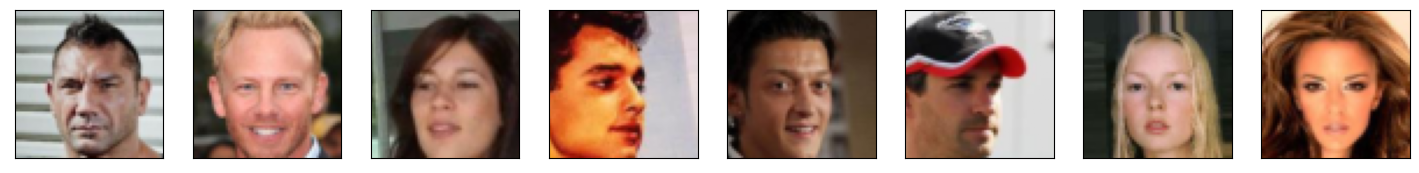

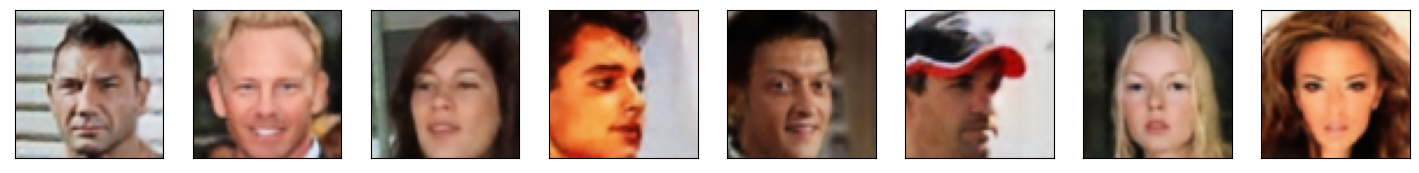

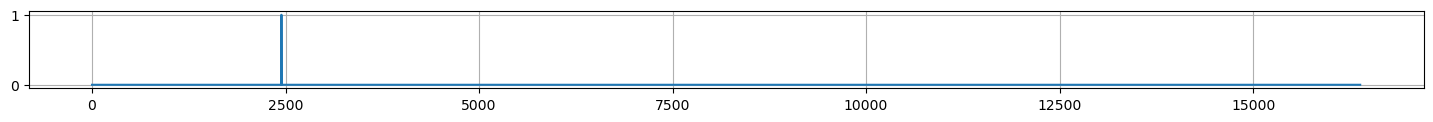

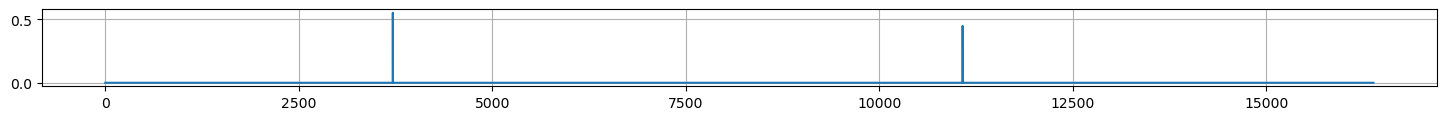

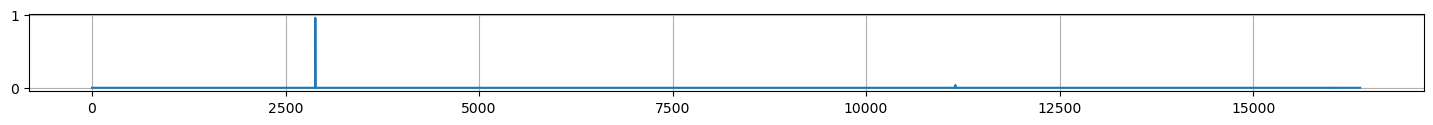

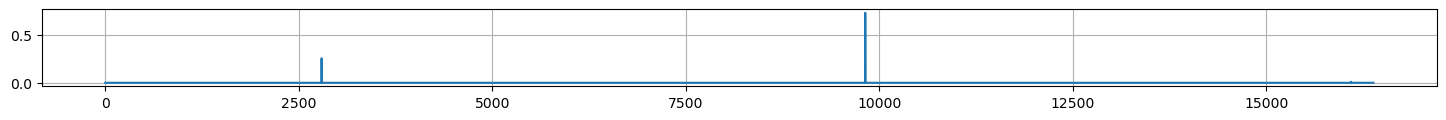

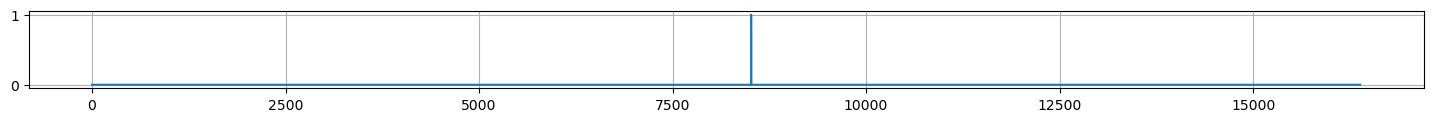

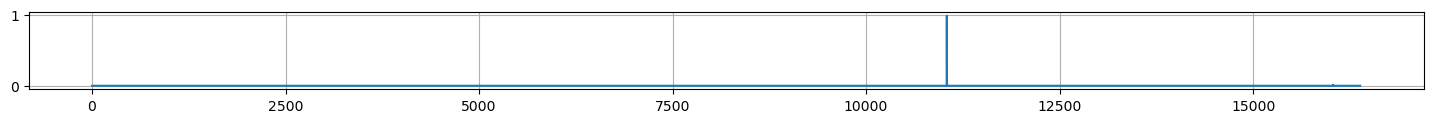

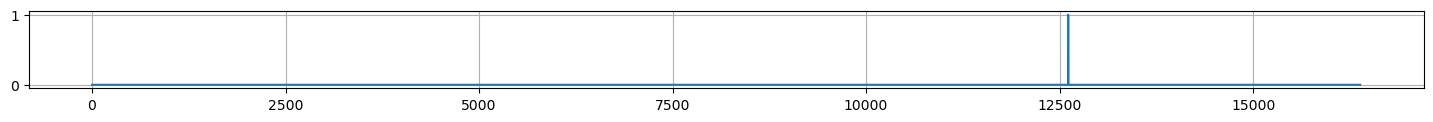

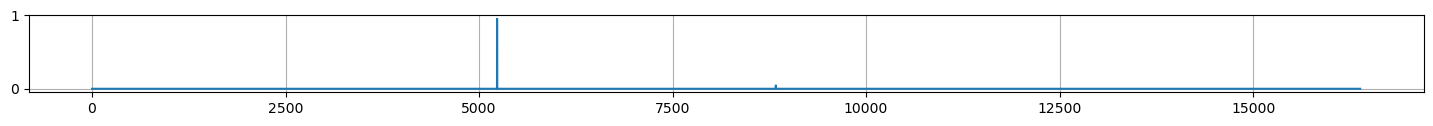

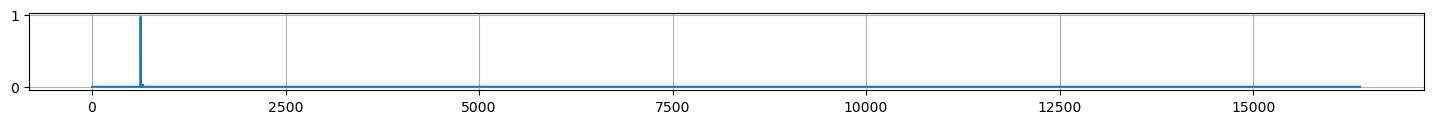

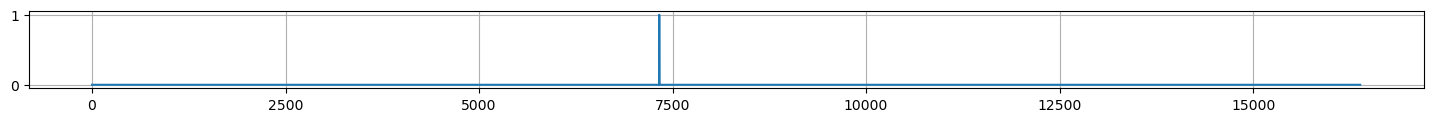

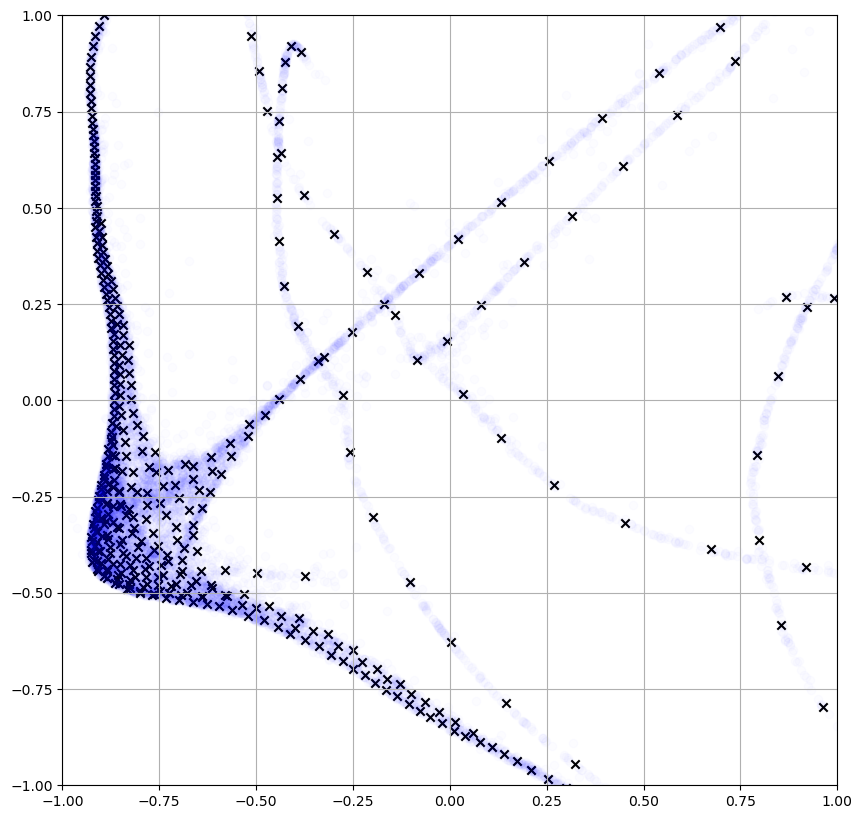

1
lse_loss -360.8490905761719
commit_loss 8.638223516754806e-05
recon_loss 0.0033038826659321785
2
lse_loss -390.7549743652344
commit_loss 8.638932195026428e-05
recon_loss 0.001543793361634016
3
lse_loss -388.5240173339844
commit_loss 8.534872176824138e-05
recon_loss 0.0017858808860182762
4
lse_loss -379.52435302734375
commit_loss 8.665335190016776e-05
recon_loss 0.0017625869950279593
5
lse_loss -385.39019775390625
commit_loss 9.303150727646425e-05
recon_loss 0.001607996178790927
6
lse_loss -385.37945556640625
commit_loss 8.779850031714886e-05
recon_loss 0.0013437735615298152
7
lse_loss -395.4192810058594
commit_loss 8.5098909039516e-05
recon_loss 0.0011159966234117746
8
lse_loss -399.5826110839844
commit_loss 8.062412234721705e-05
recon_loss 0.0012320162495598197
9
lse_loss -388.2376403808594
commit_loss 8.471730689052492e-05
recon_loss 0.0012572633568197489
10
lse_loss -392.2424621582031
commit_loss 8.232721302192658e-05
recon_loss 0.0011074597714468837
11
lse_loss -394.989990234375


lse_loss -405.19293212890625
commit_loss 7.550290320068598e-05
recon_loss 0.0007839980535209179
86
lse_loss -406.9286193847656
commit_loss 7.19012605259195e-05
recon_loss 0.0006852421793155372
87
lse_loss -413.0566101074219
commit_loss 8.024710405152291e-05
recon_loss 0.0007787693757563829
88
lse_loss -408.5791015625
commit_loss 7.85244774306193e-05
recon_loss 0.0006789717590436339
89
lse_loss -411.2491149902344
commit_loss 7.865112274885178e-05
recon_loss 0.0006874416721984744
90
lse_loss -405.7960205078125
commit_loss 7.84067960921675e-05
recon_loss 0.0007789930677972734
91
lse_loss -410.1702575683594
commit_loss 8.307057578349486e-05
recon_loss 0.001061264774762094
92
lse_loss -413.0651550292969
commit_loss 8.001818059710786e-05
recon_loss 0.000797232030890882
93
lse_loss -407.99395751953125
commit_loss 7.056220783852041e-05
recon_loss 0.0007169210584834218
94
lse_loss -407.2293395996094
commit_loss 7.839250611141324e-05
recon_loss 0.0008333976147696376
95
lse_loss -407.856994628906

171
lse_loss -405.6288146972656
commit_loss 8.284262730740011e-05
recon_loss 0.0007788866059854627
172
lse_loss -410.1795349121094
commit_loss 8.29032069304958e-05
recon_loss 0.0007659392431378365
173
lse_loss -403.1668395996094
commit_loss 8.429432637058198e-05
recon_loss 0.0007987640565261245
174
lse_loss -411.06256103515625
commit_loss 8.178303687600419e-05
recon_loss 0.0008001498645171523
175
lse_loss -410.2309265136719
commit_loss 8.087092282949015e-05
recon_loss 0.0007849234971217811
176
lse_loss -412.3642883300781
commit_loss 7.836351869627833e-05
recon_loss 0.0007247371831908822
177
lse_loss -411.1186828613281
commit_loss 8.052794146351516e-05
recon_loss 0.0008771337452344596
178
lse_loss -411.08123779296875
commit_loss 8.167417399818078e-05
recon_loss 0.00078892259625718
179
lse_loss -401.8667907714844
commit_loss 8.811798761598766e-05
recon_loss 0.0007762640016153455
180
lse_loss -412.0385437011719
commit_loss 8.456061186734587e-05
recon_loss 0.0006949643138796091
181
lse_los

255
lse_loss -404.19464111328125
commit_loss 7.67946767155081e-05
recon_loss 0.0008791350992396474
256
lse_loss -411.88592529296875
commit_loss 7.675216329516843e-05
recon_loss 0.0007103970274329185
257
lse_loss -407.3247985839844
commit_loss 7.552070019301027e-05
recon_loss 0.0007529646973125637
258
lse_loss -410.01513671875
commit_loss 7.818642916390672e-05
recon_loss 0.0007954584434628487
259
lse_loss -412.6429443359375
commit_loss 7.698997796978801e-05
recon_loss 0.0007939304923638701
260
lse_loss -407.8052062988281
commit_loss 7.496343459933996e-05
recon_loss 0.0007047331891953945
261
lse_loss -403.3853454589844
commit_loss 7.420813926728442e-05
recon_loss 0.0008131970535032451
262
lse_loss -412.3121643066406
commit_loss 8.089332550298423e-05
recon_loss 0.0006940251914784312
263
lse_loss -407.7638854980469
commit_loss 7.320674194488674e-05
recon_loss 0.0007353083929046988
264
lse_loss -411.0518493652344
commit_loss 7.609592285007238e-05
recon_loss 0.0006776461377739906
265
lse_los

339
lse_loss -406.8464660644531
commit_loss 7.20856332918629e-05
recon_loss 0.0007001959020271897
340
lse_loss -406.89190673828125
commit_loss 7.763984467601404e-05
recon_loss 0.0008156715775839984
341
lse_loss -410.08441162109375
commit_loss 7.285882020369172e-05
recon_loss 0.0007355118868872523
342
lse_loss -408.29705810546875
commit_loss 7.213815115392208e-05
recon_loss 0.0008995230309665203
343
lse_loss -405.6899108886719
commit_loss 7.583301339764148e-05
recon_loss 0.0008282407652586699
344
lse_loss -410.3631896972656
commit_loss 7.714635285083205e-05
recon_loss 0.00082970573566854
345
lse_loss -408.9505615234375
commit_loss 7.867905515013263e-05
recon_loss 0.000771379447542131
346
lse_loss -402.579345703125
commit_loss 7.5641626608558e-05
recon_loss 0.0007564794505015016
347
lse_loss -414.9324645996094
commit_loss 7.423150964314118e-05
recon_loss 0.0007725423201918602
348
lse_loss -405.9233703613281
commit_loss 7.094542525010183e-05
recon_loss 0.0008537225658074021
349
lse_loss -

422
lse_loss -410.0006408691406
commit_loss 7.240632839966565e-05
recon_loss 0.0007680599810555577
423
lse_loss -395.2587585449219
commit_loss 7.831559923943132e-05
recon_loss 0.0008010820019990206
424
lse_loss -398.8106384277344
commit_loss 7.002208440098912e-05
recon_loss 0.0007344594923779368
425
lse_loss -408.3137512207031
commit_loss 7.363274198723957e-05
recon_loss 0.0006904269102960825
426
lse_loss -396.1081848144531
commit_loss 7.409132376778871e-05
recon_loss 0.0006860018474981189
427
lse_loss -398.33990478515625
commit_loss 7.612445915583521e-05
recon_loss 0.000798144843429327
428
lse_loss -405.1166687011719
commit_loss 7.701470167376101e-05
recon_loss 0.0007147839642129838
429
lse_loss -403.4133605957031
commit_loss 7.583026308566332e-05
recon_loss 0.0007431713165715337
430
lse_loss -387.6622314453125
commit_loss 7.180367538239807e-05
recon_loss 0.0008051199838519096
431
lse_loss -406.2713317871094
commit_loss 7.5279560405761e-05
recon_loss 0.0008391981828026474
432
lse_loss

lse_loss -406.1080627441406
commit_loss 7.681240094825625e-05
recon_loss 0.0007156642968766391
506
lse_loss -402.69635009765625
commit_loss 8.106297173071653e-05
recon_loss 0.0007963459938764572
507
lse_loss -406.919677734375
commit_loss 7.548875146312639e-05
recon_loss 0.0007696442189626396
508
lse_loss -407.7933654785156
commit_loss 8.105892629828304e-05
recon_loss 0.0007706765900366008
509
lse_loss -413.7004089355469
commit_loss 7.767038914607838e-05
recon_loss 0.0006933757103979588
510
lse_loss -407.78997802734375
commit_loss 7.714360253885388e-05
recon_loss 0.0007535627810284495
511
lse_loss -412.2566833496094
commit_loss 7.94533989392221e-05
recon_loss 0.0007216252270154655
512
lse_loss -408.99554443359375
commit_loss 7.495087629649788e-05
recon_loss 0.0006789284525439143
513
lse_loss -410.42742919921875
commit_loss 7.52771957195364e-05
recon_loss 0.0009459498105570674
514
lse_loss -411.02001953125
commit_loss 7.65558288549073e-05
recon_loss 0.0008143549785017967
515
lse_loss -40

589
lse_loss -409.6979064941406
commit_loss 8.13934748293832e-05
recon_loss 0.000749854079913348
590
lse_loss -401.36090087890625
commit_loss 7.7319928095676e-05
recon_loss 0.0007574392366223037
591
lse_loss -410.0037536621094
commit_loss 7.712365186307579e-05
recon_loss 0.0008702932391315699
592
lse_loss -410.74700927734375
commit_loss 7.744313916191459e-05
recon_loss 0.0007094865432009101
593
lse_loss -405.9853515625
commit_loss 6.98308867868036e-05
recon_loss 0.0006747457082383335
594
lse_loss -405.3155212402344
commit_loss 7.051686407066882e-05
recon_loss 0.0007270093774423003
595
lse_loss -410.1570739746094
commit_loss 7.919971540104598e-05
recon_loss 0.0007578522781841457
596
lse_loss -409.19744873046875
commit_loss 7.531937444582582e-05
recon_loss 0.0007999833906069398
597
lse_loss -400.9571838378906
commit_loss 7.652767817489803e-05
recon_loss 0.0008257556473836303
598
lse_loss -410.2585754394531
commit_loss 7.508546696044505e-05
recon_loss 0.0007644196739420295
599
lse_loss -4

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = exponential(1, 0, step, 0, 200*1000, -2)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 